# Hall Effect Analysis
## Phys 431 Winter 2024: Lab 1
### Thomas Sweeney, Alex Sanchez, Seamus Richardson


## Task Summary

1. If not already done, enter the raw data into a spreadsheet, save the file(s) and make them available to the members of the group.  You should have at least 4 different tables: measurements for each probe plus the measurements of the magnetic field
2. Import the magnetic field measurements.  Calculate a mean and standard deviation for the magnetic field $B$ at the location of the probes between the poles.
3. Import the measurements from each probe. Calculate $2V_H$ for each value of $I_x$  for each probe, as described in the instructions.  Show a code snippet that does this or describe the calculation in your group notebook with an example.
4. Plot $2V_H$ versus $I_x$  for each sample and fit a line to it using LMfit.  Obtain the fit coefficients and their uncertainty.
5. Calculate the Hall coefficient $R_H$ for each probe and propagate the uncertainty from the fit, uncertainty in the magnetic field, and uncertainties in the probe specifications given in Table 1 in the instructions.
6. Determine the source of the largest statistical uncertainty, and explain how this was determined.
7. Calculate the conductivity of the sample material and its uncertainty for all three samples.
8. Calculate the Hall mobility $\mu$ for the InAs probe.  (You can also calculate a mobility for the metal probes, but its meaning is suspect.)

In [1]:
# Usually import packages via a handle to the functions in them using import ... as ...
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import uncertainties as unc
%matplotlib inline

In [2]:
# Useful plot default
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 12 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font

## Read in the B-field data

If the data files are spreadsheet files with comma-separated values (CSV) they can be read in with Pandas `pd.read_csv()`:
    
    B_data = pd.read_csv('Hall_magnet_measurements.csv')


In [3]:
# You code this


B_data = pd.read_csv('./Hall-Effect-Data/Voltage Readings - Probing magnet.csv')


Calculate the average value of the field and its standard deviation, correcting for the sign reversal.  One way to do this is to create a new NumPy array that holds all values as absolute-values, and then use the methods within the array.  

In [4]:
# You code this
B_abs_data = B_data.drop(columns=['Position'])
# Divide by 10 to convert to Tesla
B_abs_data = np.abs(B_abs_data.to_numpy().flatten()) / 10

B = np.mean(B_abs_data)
sigma_B  = np.std(B_abs_data)

In [5]:
# Create an uncertainty object that holds the feild and its uncertainty.

# You need the values of B and its uncertainty
uB = unc.ufloat(B,sigma_B,'B') # the extra label is a "tag" that can be used with some of the Uncertainties functions
print('The field strength of the magnet = {:.4uP} T'.format(uB))

The field strength of the magnet = 0.129491±0.005968 T


## Read in the probe data

As before, use `pd.read_csv()`.

Then for each, create an array that gives $2V_H$, twice the hall voltage.  Be careful with signs!

In [6]:
# Start with aluminum probe data
# You code this
al_df = pd.read_csv('./Hall-Effect-Data/Voltage Readings - Aluminum.csv')
drop_columns = ['delta V (mV)', 'delta V mean', 'Unnamed: 5','Deviation']
al_df = al_df.drop(columns=drop_columns)
al_df.head()

,Current (mA),Voltage White up (mV),Voltage green up (mV)
0,30.24,0.10155,0.10218
1,30.24,0.10150,0.10200
2,30.24,0.10148,0.10207
3,60.01,0.20069,0.20213
4,60.01,0.20055,0.20203


In [7]:
def create_2V_H(df:pd.DataFrame) -> None:
    '''
    Adds a column to the dataframe that contains 2V_H. This is the difference between the two voltage columns
    '''
    df['2V_H (mV)'] = df['Voltage green up (mV)'] - df['Voltage White up (mV)']


In [8]:
# Calculate 2VH
# Recommended: add it as a column in the existing dataframe.

create_2V_H(al_df)

al_df.head()

,Current (mA),Voltage White up (mV),Voltage green up (mV),2V_H (mV)
0,30.24,0.10155,0.10218,0.00063
1,30.24,0.10150,0.10200,0.00050
2,30.24,0.10148,0.10207,0.00059
3,60.01,0.20069,0.20213,0.00144
4,60.01,0.20055,0.20203,0.00148


In [9]:
# Repeat for gold probe data

# read in data and remove unecissary columns
au_df = pd.read_csv('./Hall-Effect-Data/Voltage Readings - Gold.csv')
drop_columns = ['delta V (mV)', 'delta V mean', 'Unnamed: 5','Deviation']
au_df = au_df.drop(columns=drop_columns)


# Add the 2V_H column

create_2V_H(au_df)
au_df.head()


,Current (mA),Voltage White up (mV),Voltage green up (mV),2V_H (mV)
0,30.53,-0.02334,-0.01992,0.00342
1,30.53,-0.02338,-0.01992,0.00346
2,30.53,-0.02351,-0.01998,0.00353
3,60.67,-0.04761,-0.04088,0.00673
4,60.67,-0.04765,-0.04094,0.00671


In [10]:
# Repeat for InAs probe data

# read in data and remove unecissary columns
InAs_df = pd.read_csv('./Hall-Effect-Data/Voltage Readings - Semiconductor.csv')
drop_columns = ['delta V (mV)', 'delta V mean', 'Unnamed: 5','Deviation']
InAs_df = InAs_df.drop(columns=drop_columns)


# Add the 2V_H column

create_2V_H(InAs_df)
InAs_df.head()


,Current (mA),Voltage White up (mV),Voltage green up (mV),2V_H (mV)
0,15.02,-2.62340,2.65821,5.28161
1,15.02,-2.62310,2.65763,5.28073
2,15.02,-2.62435,2.65710,5.28145
3,30.04,-5.24493,5.31124,10.55617
4,30.04,-5.24350,5.31165,10.55515


Before Plotting I will need to do some averaging as we have multiple readings of 2V_H for each value of the current. So I will go through and take the average of the 2V_H value for each of the currents.

In [11]:
def get_averaged_df(df:pd.DataFrame) -> pd.DataFrame:
    '''
    This function finds the unique values of current and averages the 2V_H values corresponding to that current.
    Then it creates a new dataframe containing this averaged data.
    '''
    current_list = df['Current (mA) '].unique().tolist()

    averaged_list = []

    for current in current_list:
        temp_dict = {}
        temp_dict['Current (mA)'] = current
        temp_dict['2V_H (mV)'] = np.mean(df[df['Current (mA) '] == current]['2V_H (mV)'])
        averaged_list.append(temp_dict)

    return pd.DataFrame(averaged_list)

In [12]:
# call our get averaged df function
al_averaged_df = get_averaged_df(al_df)
au_averaged_df = get_averaged_df(au_df)
InAs_averaged_df = get_averaged_df(InAs_df)

## Make a couple of plots

The metal probes typically have similar Hall voltages. You should plot them on the same graph to compare, but InAs has much higher values and would need its own plot.

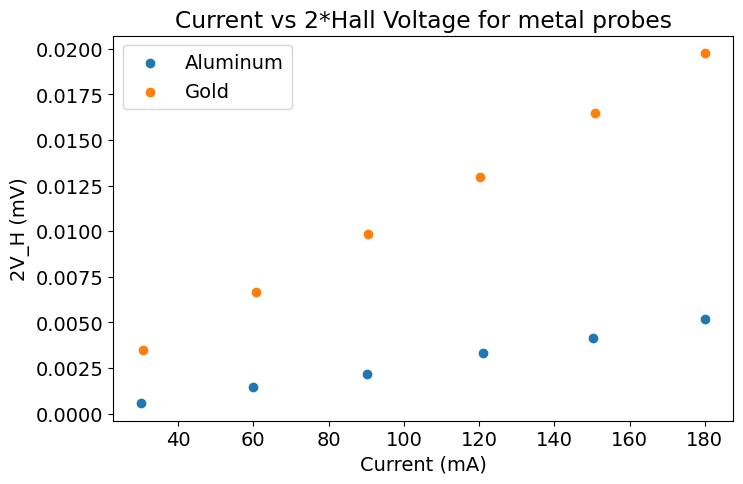

In [13]:
# See the examples for how to make a plot
# Metal probes first.

fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(al_averaged_df['Current (mA)'], al_averaged_df['2V_H (mV)'], label='Aluminum')
ax.scatter(au_averaged_df['Current (mA)'], au_averaged_df['2V_H (mV)'], label='Gold')
ax.set_xlabel('Current (mA)')
ax.set_ylabel('2V_H (mV)')
ax.set_title('Current vs 2*Hall Voltage for metal probes')
ax.legend()






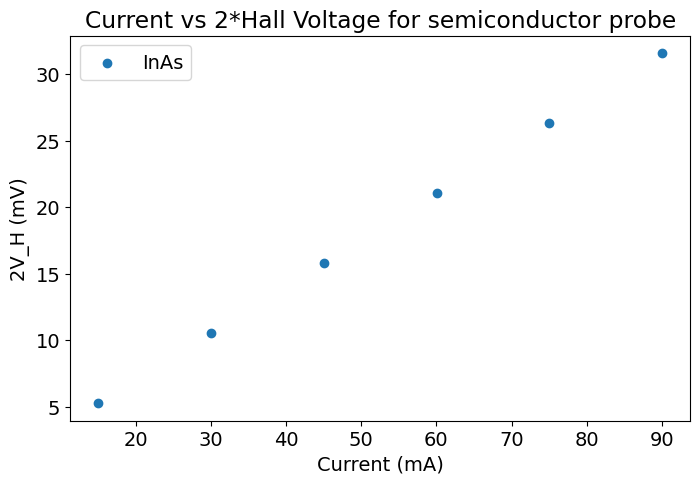

In [14]:
# Plot data for InAs probe

fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(InAs_averaged_df['Current (mA)'], InAs_averaged_df['2V_H (mV)'], label='InAs')
ax.set_xlabel('Current (mA)')
ax.set_ylabel('2V_H (mV)')
ax.set_title('Current vs 2*Hall Voltage for semiconductor probe')
ax.legend()

## Fit the data to extract the slope of $2V_H/I_x$

Use LMfit.  See the examples.

In [15]:
# Set  up the Model  This cell does the import and model instance creation
# !pip install lmfit
# Import the Linear model.
# You only do this once in a notebook
from lmfit.models import LinearModel

# create an instance of the model
# You only need to do this once
line = LinearModel()


In [16]:
# Aluminum first
#
# Get starting parameters with the guess() method
al_param_guess = line.guess(al_averaged_df['2V_H (mV)'], x=al_averaged_df['Current (mA)'])


# Feed these into the fitter and run it.

Al_fit = line.fit(al_averaged_df['2V_H (mV)'], al_param_guess, x=al_averaged_df['Current (mA)'])

# Print the results
Al_fit

<Axes: title={'center': 'Al 2V_H vs Current'}, xlabel='Current (mA)', ylabel='2V_H (mV)'>

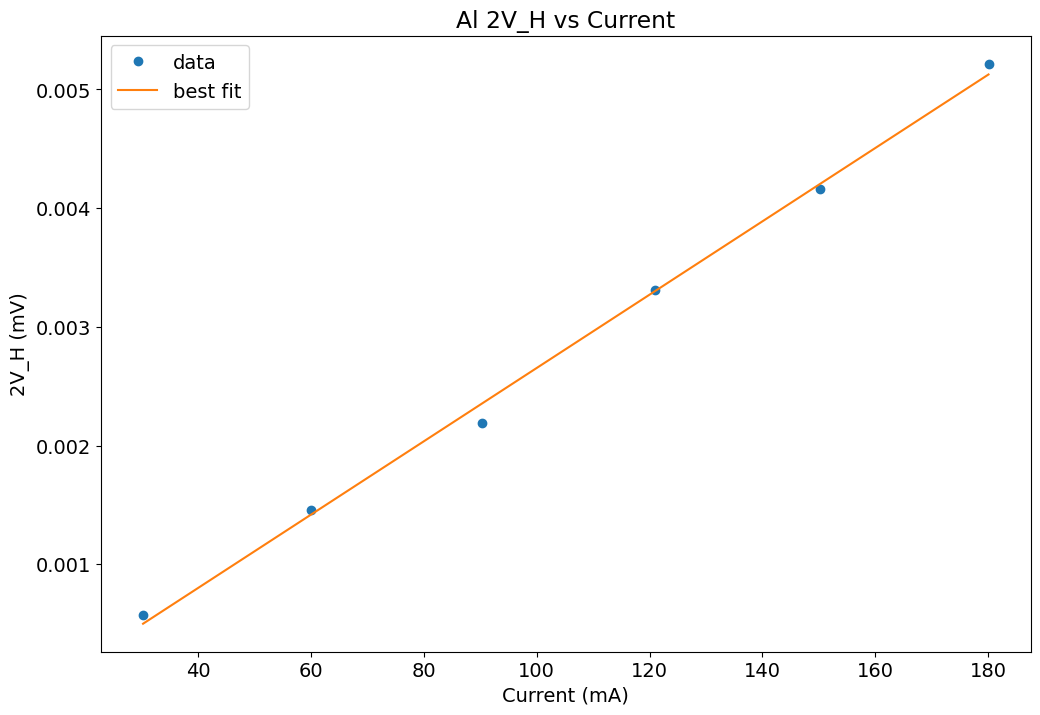

In [17]:
# Make a plot

Al_fit.plot_fit(xlabel='Current (mA)', ylabel='2V_H (mV)', title='Al 2V_H vs Current')

### Extract the slope with uncertainty from the fit parameters


In [18]:
# See the examples for how to access fit parameters from the fit results
Al_slope = Al_fit.params['slope'].value


unc_al_slope = unc.ufloat(Al_slope, Al_fit.params['slope'].stderr, 'Al_slope')


# When you have the uncertainty object Al_slope, you can print it out this way:
print('2VH/Ix for aluminum = {:.2uP} mV/mA'.format(unc_al_slope))

2VH/Ix for aluminum = (3.089±0.085)×10⁻⁵ mV/mA


### Calculate the Hall coefficient

The Hall coefficient $R_H$ is related to the measurements by

$$V_H = -R_H\frac{I_xB_z}{t}$$

where $t$ is the thichness of the sample strip.  From the linefit, we have the slope $m = 2V_H/I_x$  so

$$R_H = -m\frac{t}{2B_z}$$

In the instructions there is a list of probe parameters.  Use these to calculate the Hall coefficient and its statistical uncertainty.


In [19]:
# For Al, from Table 1, create uncertainty object for thickness

t_Al = unc.ufloat(2.34e-7, 0.17e-7,'t_Al')

RH_Al = - unc_al_slope * t_Al / (2*uB)

# Then calculate the Hall coefficient using your uncertainty object for B and the thickness.

print('The Hall coefficient for the aluminum probe is {:.2uP} m^3/A-s'.format(RH_Al))

# Here is an example of how to extract the relative contributions of the different
# quantities that go into the calculation.  See how the "tags" are used.

print('Percent contribution to statistical uncertainty:')
for (var,error) in RH_Al.error_components().items():
    print('{:>6s}: {:.3%}'.format(var.tag,(error/RH_Al.s)**2))


The Hall coefficient for the aluminum probe is (-2.79±0.25)×10⁻¹¹ m^3/A-s
Percent contribution to statistical uncertainty:
     B: 26.059%
  t_Al: 64.748%
Al_slope: 9.192%


## Repeat above for other samples

### Gold probe

Comments are minimal.

In [20]:
# Gold
#
# Run the fit



au_param_guess = line.guess(au_averaged_df['2V_H (mV)'], x=au_averaged_df['Current (mA)'])


# Feed these into the fitter and run it.

Au_fit = line.fit(au_averaged_df['2V_H (mV)'], au_param_guess, x=au_averaged_df['Current (mA)'])

# Print the results
Au_fit


<Axes: title={'center': 'Au 2V_H vs Current'}, xlabel='Current (mA)', ylabel='2V_H (mV)'>

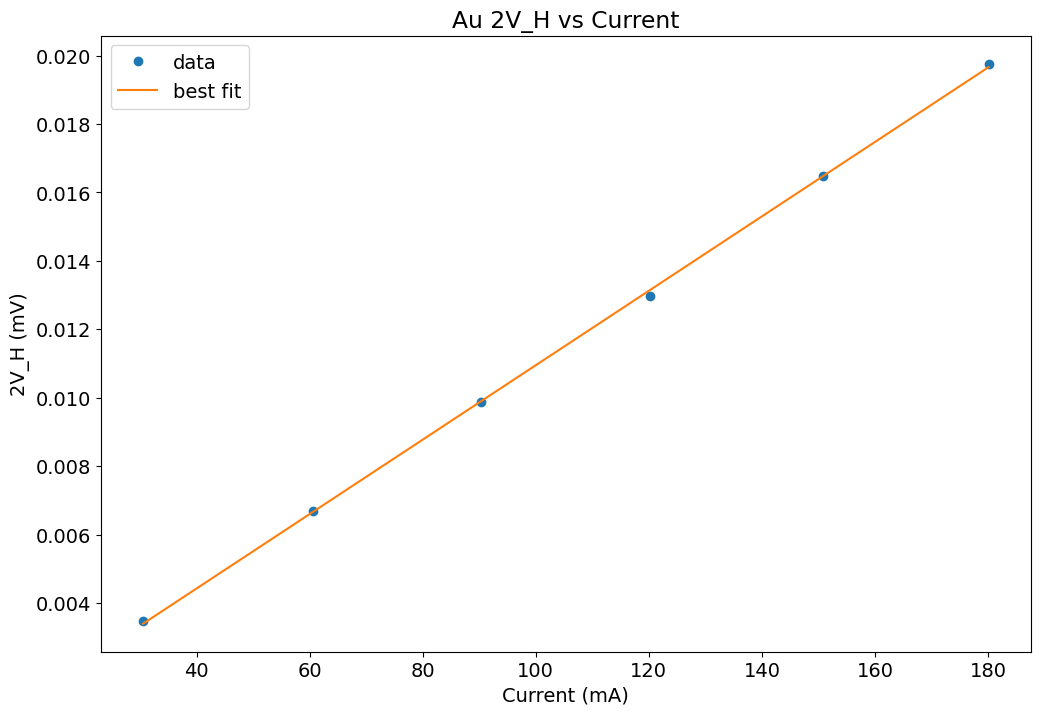

In [21]:
# Make a plot
Au_fit.plot_fit(xlabel='Current (mA)', ylabel='2V_H (mV)', title='Au 2V_H vs Current')


In [22]:
# Get the slope, make an uncertainty object, and print it out

# See the examples for how to access fit parameters from the fit results
Au_slope = Au_fit.params['slope'].value


unc_au_slope = unc.ufloat(Au_slope, Au_fit.params['slope'].stderr, 'Au_slope')


# When you have the uncertainty object Al_slope, you can print it out this way:
print('2VH/Ix for gold = {:.2uP} mV/mA'.format(unc_au_slope))

2VH/Ix for gold = 0.00010871±0.00000082 mV/mA


In [23]:

print(Au_slope)

0.00010870758715181676


In [24]:
# Get the thickness, calculate the Hall coefficient and print out the relative error contributions.

t_Au = unc.ufloat(1.37e-7, 0.17e-7,'t_Au')

RH_Au = - unc_au_slope * t_Au / (2*uB)

# Then calculate the Hall coefficient using your uncertainty object for B and the thickness.

print('The Hall coefficient for the gold probe is {:.2uP} m^3/A-s'.format(RH_Au))

print('Percent contribution to statistical uncertainty:')
for (var,error) in RH_Au.error_components().items():
    print('{:>6s}: {:.3%}'.format(var.tag,(error/RH_Au.s)**2))

The Hall coefficient for the gold probe is (-5.75±0.76)×10⁻¹¹ m^3/A-s
Percent contribution to statistical uncertainty:
     B: 12.084%
  t_Au: 87.592%
Au_slope: 0.325%


### InAs probe

In [25]:
# Indium-Arsenide
#
# Run the fit

InAs_param_guess = line.guess(InAs_averaged_df['2V_H (mV)'], x=InAs_averaged_df['Current (mA)'])


# Feed these into the fitter and run it.

InAs_fit = line.fit(InAs_averaged_df['2V_H (mV)'], InAs_param_guess, x=InAs_averaged_df['Current (mA)'])

# Print the results
InAs_fit


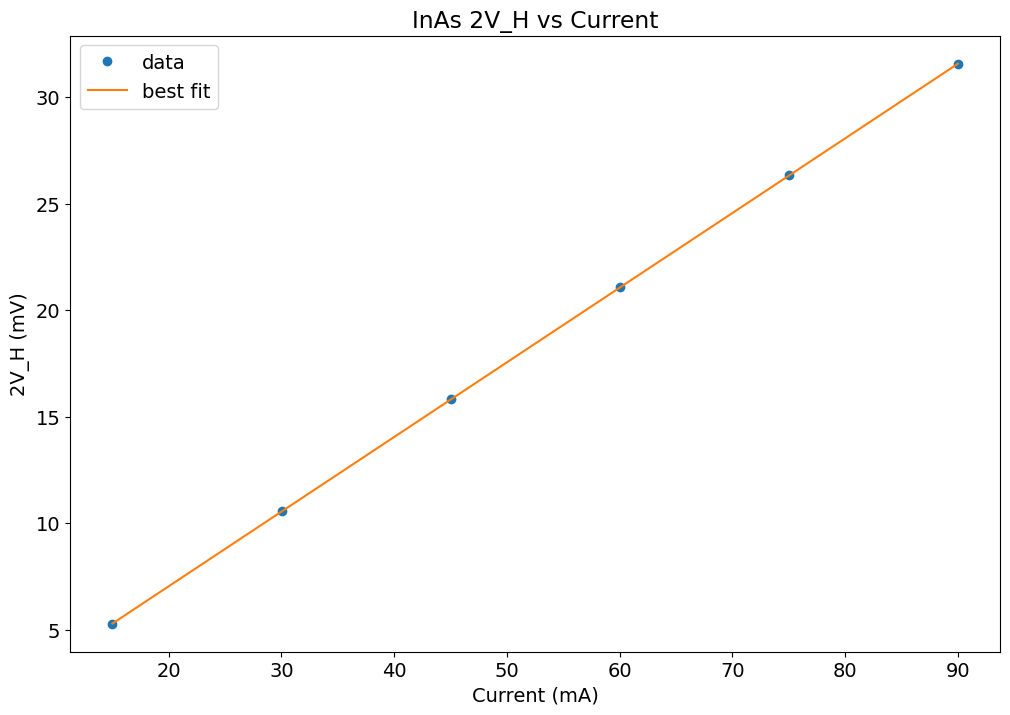

In [26]:
# Make a plot

InAs_fit.plot_fit(xlabel='Current (mA)', ylabel='2V_H (mV)', title='InAs 2V_H vs Current');

In [27]:
# Get the slope, make an uncertainty object, and print it out

# See the examples for how to access fit parameters from the fit results
InAs_slope = InAs_fit.params['slope'].value


unc_InAs_slope = unc.ufloat(InAs_slope, InAs_fit.params['slope'].stderr, 'InAs_slope')


# When you have the uncertainty object Al_slope, you can print it out this way:
print('2VH/Ix for InAs = {:.2uP} mV/mA'.format(unc_InAs_slope))

2VH/Ix for InAs = 0.35041±0.00015 mV/mA


In [28]:
# Get the thickness, calculate the Hall coefficient and print out the relative error contributions.

t_InAs = unc.ufloat(1.26e-4, 0.02e-4,'t_InAs')

RH_InAs = - unc_InAs_slope * t_InAs / (2*uB)

# Then calculate the Hall coefficient using your uncertainty object for B and the thickness.

print('The Hall coefficient for the InAs probe is {:.2uP} m^3/A-s'.format(RH_InAs))

print('Percent contribution to statistical uncertainty:')
for (var,error) in RH_InAs.error_components().items():
    print('{:>6s}: {:.3%}'.format(var.tag,(error/RH_InAs.s)**2))

The Hall coefficient for the InAs probe is -0.0001705±0.0000083 m^3/A-s
Percent contribution to statistical uncertainty:
     B: 89.390%
t_InAs: 10.602%
InAs_slope: 0.008%


## Conductivity calculations

From equation (13) in the instructions

$$\sigma = \frac{\ell}{Rwt}$$

We use the data in table 1.

In [29]:
# Create uncertainty objects from the data in Table 1 for each sample

# All are

# Gold:

w_Au = unc.ufloat(0.0127,5e-5,'w_Au')
l_Au = unc.ufloat(0.0305, 5e-5, 'l_Au')
R_Au = unc.ufloat(0.77, 0.006, 'R_Au')


# Aluminum:

w_Al = unc.ufloat(0.0127,5e-5, 'w_Al')
l_Al = unc.ufloat(0.0305, 5e-5, 'l_Al')
R_Al = unc.ufloat(0.872, 0.018, 'R_Al')

# InAs:
w_InAs = unc.ufloat(0.000692, 4e-06, 'w_InAs')
l_InAs = unc.ufloat(0.001542, 5e-06, 'l_InAs')
R_InAs = unc.ufloat(1.3, 0.3, 'R_InAs')


# Calculate the conductivity for each sample from the above




# Print the results WITH UNITS for each sample
sigma_Au = l_Au /(R_Au * w_Au * t_Au)
print(fr'The conductivity for the gold sample is: {sigma_Au} * 1/(Ohm * m)')

sigma_Al = l_Al /(R_Al * w_Al * t_Al)
print(f'The conductivity for the aluminum sample is: {sigma_Al} * 1/(Ohm * m)')

sigma_InAs = l_InAs /(R_InAs * w_InAs * t_InAs)
print(f'The conductivity for the aluminum sample is: {sigma_InAs} * 1/(Ohm * m)')

The conductivity for the gold sample is: (2.28+/-0.28)e+07 * 1/(Ohm * m)
The conductivity for the aluminum sample is: (1.18+/-0.09)e+07 * 1/(Ohm * m)
The conductivity for the aluminum sample is: (1.36+/-0.31)e+04 * 1/(Ohm * m)


### Calculate mobility for InAs probe

(Metal probe "mobility" is optional, because it does not mean very much.) From exercise 4

$$\mu = \sigma R_H$$

In [30]:
# Calculate the Carrier density of the InAs probe from the Hall coefficient and charge of the electron

# Scientific constants are in SciPy
import scipy.constants as const
const.e # electron charge in coulombs

# Calculate the carrier density and print it WITH UNITS
n_InAs = 1 / (-1*const.e * RH_InAs)

print(f'The carrier density for the InAs Probe is: {n_InAs} * 1/m^3')

# Claculate the mobility and print it WITH UNITS

mu_InAs = sigma_InAs * RH_InAs

print(f'The mobility for the InAs probe is: {-1 * mu_InAs} * m^2 /(V *s)')

The carrier density for the InAs Probe is: (3.66+/-0.18)e+22 * 1/m^3
The mobility for the InAs probe is: 2.3+/-0.5 * m^2 /(V *s)


In [31]:
# Optional: Mobility for metals, just because we can


In [8]:
print(f'{9e13 * 1.136:.3e}') 


1.022e+14
